## Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# change path to reflect your env
%cd /content/gdrive/MyDrive/ml-final/ML-Final-Project
! pip3 install -r requirements.txt

/content/gdrive/MyDrive/ml-final/ML-Final-Project
  Using cached numpy-1.23.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.13.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.5.2 which is incompatible.


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/ml-final/ML-Final-Project/src')
sys.path.append('/content/drive/MyDrive/ml-final/ML-Final-Project/src/utils')

%cd /content/gdrive/MyDrive/ml-final/ML-Final-Project/src

/content/gdrive/MyDrive/ml-final/ML-Final-Project/src


In [2]:
#!pip install numpy --upgrade
!pip install cebra
#!pip install h5py


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import joblib as jl
import cebra.datasets
from cebra import CEBRA
import utils.nets as CONV_iVAE
from utils.model_tools import *
import utils.ciivae_etc as UTIL
from scipy.ndimage import gaussian_filter1d

/opt/conda/lib/python3.10/site-packages/cebra/datasets/monkey_reaching.py:24: UserWarning: Could not import the nlb_tools package required for data loading of cebra.datasets.monkey_reaching. Dataset will not be available. If required, you can install the dataset by running pip install git+https://github.com/neurallatents/nlb_tools.
  warnings.warn(


In [2]:
!pip install 'cebra[datasets,demos]'
#os.environ['CEBRA_DATADIR'] = "./data"


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 420

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
ls data/rat_hippocampus/

achilles.jl  buddy.jl  cicero.jl  gatsby.jl


## Import data/Preprocess

In [5]:
DATA_NAME = 'rat-hippocampus-achilles-3fold-trial-split-0'
offset_right = 5
offset_left = 5

def _call_dataset(offset_right, offset_left, split):
    dataset = cebra.datasets.init(DATA_NAME, split = split)
    dataset.offset.right = offset_right
    dataset.offset.left = offset_left
    return dataset

train_set = _call_dataset(offset_right, offset_left, 'train')
valid_set=_call_dataset(offset_right, offset_left, 'valid')
test_set=_call_dataset(offset_right, offset_left, 'test')

In [6]:
def custom_data_generator(x,u):
    while True:
        for ii in range(len(x)):
            yield ([x[ii], u[ii]], None)
            
def make_loader(dataset, batch_size):
    def _to_batch_list(x, y, batch_size):
        if x is not None and y is not None:
            x = x.squeeze()
            if len(x.shape) == 3:
                x = x.transpose(0,2,1) 
            x_batch_list = np.array_split(x, int(len(x) / batch_size))
            y_batch_list = np.array_split(y, int(len(y) / batch_size))
        else:
            return None, None
        return x_batch_list, y_batch_list
    
    x,u = _to_batch_list(dataset[torch.arange(len(dataset))].numpy(), dataset.index.numpy(), batch_size)
    
    loader = custom_data_generator(x, u)
    
    _len = len(x)
    return x, u, loader

In [7]:
batch_size = 200
train_x, train_u, train_loader = make_loader(train_set, batch_size)
valid_x, valid_u, valid_loader = make_loader(valid_set, batch_size)
test_x, test_u, test_loader = make_loader(test_set, batch_size)

Visualized the Data

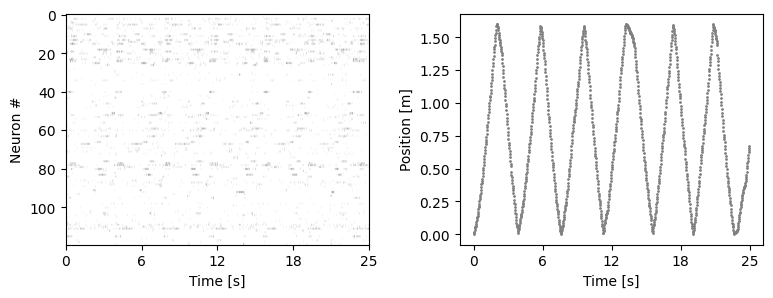

In [8]:
fig = plt.figure(figsize=(9,3))
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(train_set.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), train_set.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

## Train CI-iVAE

In [46]:
ci_ivae = CIiVAE(dim_x=train_set.neural.shape[1], dim_u=3, dim_z=2) #CONV_iVAE.ConvCIiVAE(dim_x=train_set.neural.shape[1], dim_u=3, dim_z=2)

# train_x is a list of batches typically handled by the loader. TODO figure out how to do that in our implementation
# also: they say something about applying the pi-vae preprocessing script to this data
# it's unclear if they actually run the script while loading it or if we should
# but that code is available so if we need to it's not a big deal

dataloader_dict = {}
dataloader_dict['train'] = train_loader
dataloader_dict['val'] = valid_loader
dataloader_dict['test'] = test_loader

# # train CI-iVAE networks. Results will be saved at the result_path
fit(model=ci_ivae, dataloader_dict=dataloader_dict, seed=seed)
#CONV_iVAE.fit(model=ci_ivae, x_train=train_x, u_train=train_u,
#            x_val=valid_x, u_val=valid_u, seed=seed)

[Epoch 1/100] Training: 0it [00:00, ?it/s]

torch.Size([120, 120, 10])
[[[1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  ...
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]]

 [[1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  ...
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]]

 [[1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.7843798 2.2633116 3.064552  ... 7.9354477 8.736689  9.21562  ]
  [1.

[Epoch 1/100] Training: 0it [00:01, ?it/s]


KeyboardInterrupt: 

In [45]:
import math
# adapting from https://discuss.pytorch.org/t/1d-gaussian-kernel/160899/2

# https://stackoverflow.com/questions/3149279/optimal-sigma-for-gaussian-filtering-of-an-image
# sigma=(k-1)/6

# TODO make sure that this makes any sense lol
# kernel should be shape [120,120,10]
def gaussian_conv(x, sigma):
    weights = torch.arange(1, 11, dtype=torch.float, device=x.device)
    weights = torch.unsqueeze(weights, 0)
    weights = torch.unsqueeze(weights, 0)
    weights = weights.expand(x.size(1), x.size(1), -1)
    print(weights.shape)
    kernel = gaussian_filter1d(weights, sigma)
    print(kernel)
    
    return torch.nn.functional.conv1d(x, torch.from_numpy(kernel))

In [26]:
'''
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import random
import sys
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from sklearn.preprocessing import OneHotEncoder
# import progressbar
import tqdm
'''

import utils.ciivae_etc as UTIL
from scipy.ndimage import gaussian_filter1d

# NOTE: their models are lists of modules (which are optimized seperately in train) instead of actual Pytorch models. We're ollowing that convention for now.
# Code taken from CI-iVAE repo

def CIiVAE(dim_x, dim_u,
          dim_z=16, prior_node_list=[128, 128],
          encoder_node_list=[4096, 4096],
          decoder_node_list=[4096, 4096],
          decoder_final_activation='sigmoid'):
    '''
    dim_z: dimension of representations
    prior_node_list: list of number of nodes in layers in label prior networks
    encoder_node_list: list of number of nodes in layers in encoder networks
    decoder_node_list: list of number of nodes in layers in decoder networks
    decoder_final_activation: the last activation layer in decoder. Please choose 'sigmoid' or 'None' 
    '''
    
    prior = Prior_conti(dim_z, dim_u, prior_node_list)
    encoder = Encoder(dim_x, dim_z, encoder_node_list)
    decoder = Decoder(dim_z, dim_x, decoder_node_list,
                            final_activation=decoder_final_activation)
    return [prior, encoder, decoder]


# encoder changed to the cebra one, decoder changed to 2d output
# not sure what that means for the output
def ConvCIiVAE(dim_x, dim_u,
          dim_z=16,
          decoder_final_activation='sigmoid',
          time_window=10,
          gen_nodes=60):
    '''
    dim_z: dimension of representations
    prior_node_list: list of number of nodes in layers in label prior networks
    encoder_node_list: list of number of nodes in layers in encoder networks
    decoder_node_list: list of number of nodes in layers in decoder networks
    decoder_final_activation: the last activation layer in decoder. Please choose 'sigmoid' or 'None' 
    '''
    
    prior = Prior_conti(dim_z, dim_u)
    encoder = CebraConvEncoder(dim_x, dim_z, time_window, gen_nodes)
    decoder = Decoder(dim_z, dim_x, final_activation=decoder_final_activation)
    return [prior, encoder, decoder]

class Encoder(nn.Module):
    def __init__(self, dim_x, dim_z, encoder_node_list):
        super(Encoder, self).__init__()
        
        self.dim_x, self.dim_z = dim_x, dim_z
        self.encoder_node_list = encoder_node_list # hidden dims
        
        self.main = nn.ModuleList()
        
        # input dimension is dim_x
        self.main.append(nn.Linear(self.dim_x, self.encoder_node_list[0]))
        self.main.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        if len(self.encoder_node_list) > 1:
            for i in range(len(self.encoder_node_list)-1):
                self.main.append(nn.Linear(self.encoder_node_list[i],
                                          self.encoder_node_list[i+1]))
                self.main.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        # input dimension is gen_nodes
        self.mu_net = nn.Linear(self.encoder_node_list[-1], self.dim_z)
        self.log_var_net = nn.Linear(self.encoder_node_list[-1], self.dim_z)
    
    def forward(self, x_input):
        h = self.main[0](x_input)
        
        if len(self.main) > 1:
            for i in range(len(self.main)-1):
                h = self.main[i+1](h)

        mu, log_var = self.mu_net(h), self.log_var_net(h)
        
        return mu, log_var


def fit(model, dataloader_dict,
        num_epoch=100, batch_size=256, num_worker=32, seed=0,
        beta=0.01, Adam_beta1=0.5, Adam_beta2=0.999, weight_decay=5e-6,
        init_lr=5e-5, lr_milestones=[25, 50, 75], lr_gamma=0.5,
        dtype=torch.float32, M=50, alpha_step=0.025,
        fix_alpha=None, result_path=None, sigma=9/6):
    '''
    num_epoch: the number of epoch
    batch_size: the number of samples in each mini-batch
    num_worker: the number of CPU cores
    seed: the random seed number
    beta: the coefficient of KL-penalty term in ELBOs
    Adam_beta1: beta1 for Adam optimizer
    Adam_beta2: beta2 for Adam optimizer
    weight_decay: the coefficient of the half of L2 penalty term
    init_lr: the initial learning rate
    lr_milestones: the epochs to reduce the learning rate
    lr_gamma: the multiplier for each time learning rate is reduced
    dtype: the data type
    M: the number of MC samples to approximate skew KL-divergences
    alpha_step: the distance between each grid points in finding samplewise optimal alpha
    fix_alpha: If it is None, the objective function is supremum of ELBO(\alpha) over \alpha. If it is a real number in [0, 1], the objective function is the ELBO(\alpha). For example, when it is 0.0, the objective is the ELBO of iVAEs.
    result_path: the directory where results are saved
    '''
    
    # declare basic variables
    prior, encoder, decoder = model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    beta_kl_post_prior = beta
    beta_kl_encoded_prior = beta
    Adam_betas = (Adam_beta1, Adam_beta2)
    if result_path is None:
        now = datetime.datetime.now()
        result_path = './results/ci_ivae-time=%d-%d-%d-%d-%d' % (now.month, now.day, now.hour, now.minute, now.second)
    os.makedirs(result_path, exist_ok=True)
    
    # lines for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # define optimizers and schedulers
    enc_optimizer = torch.optim.Adam(encoder.parameters(),
                                     betas=Adam_betas,
                                     lr=init_lr,
                                     weight_decay=weight_decay)
    gen_optimizer = torch.optim.Adam(list(decoder.parameters())
                                     +list(prior.parameters()),
                                     betas=Adam_betas,
                                     lr=init_lr,
                                     weight_decay=weight_decay)

    enc_scheduler = torch.optim.lr_scheduler.MultiStepLR(enc_optimizer,
                                                         milestones=lr_milestones,
                                                         gamma=lr_gamma)
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(gen_optimizer,
                                                         milestones=lr_milestones,
                                                         gamma=lr_gamma)

    # define training log    
    loss_names = ['loss', 'recon_loss_post', 'kl_post_prior',
                  'recon_loss_encoded', 'kl_encoded_prior', 'l2_penalty']
    logs = {}
    for datasetname in ['train', 'val']:
        logs[datasetname] = {}
        for loss_name in loss_names:
            logs[datasetname][loss_name] = []
            
    summary_stats = []
    
    # training part
    mse_criterion = torch.nn.MSELoss()
    if device == 'cuda':
        prior.cuda()
        encoder.cuda()
        decoder.cuda()
        mse_criterion.cuda()
    for epoch in range(1, num_epoch+1):
        num_batch = 0
        maggie = 0
        for batch, _ in tqdm.tqdm(dataloader_dict['train'],
                                         desc='[Epoch %d/%d] Training' % (epoch, num_epoch)):
            if maggie == 10:
              break
            else:
              maggie += 1
            
            
            x_batch = torch.from_numpy(batch[0])
            u_batch = torch.from_numpy(batch[1])
            
            num_batch += 1
            if device == 'cuda':
                x_batch, u_batch = x_batch.cuda(), u_batch.cuda()
            x_batch += torch.randn_like(x_batch)*1e-2

            prior.train()
            encoder.train()
            decoder.train()

            enc_optimizer.zero_grad()
            gen_optimizer.zero_grad()

            # forward step
            lam_mean, lam_log_var = prior(u_batch)
            
            x_batch_reshape = torch.transpose(x_batch, 1, 2)
            
            x_batch_fire_rate = torch.squeeze(gaussian_conv(x_batch_reshape, sigma))
            
            z_mean, z_log_var = encoder(x_batch_fire_rate)
            
            z_mean = torch.squeeze(z_mean)
            z_log_var = torch.squeeze(z_log_var)
            
            post_mean, post_log_var = UTIL.compute_posterior(z_mean, z_log_var, lam_mean, lam_log_var)
            post_sample = UTIL.sampling(post_mean, post_log_var)
            encoded_sample = UTIL.sampling(z_mean, z_log_var)

            epsilon = torch.randn((z_mean.shape[0], z_mean.shape[1], M))
            if device == 'cuda':
                post_sample = post_sample.cuda()
                encoded_sample = encoded_sample.cuda()
                epsilon = epsilon.cuda()
                
            fire_rate_post = decoder(post_sample)
            fire_rate_encoded = decoder(encoded_sample)
            
            obs_loglik_post = -torch.mean((fire_rate_post - x_batch_fire_rate)**2, dim=1)
            obs_loglik_encoded = -torch.mean((fire_rate_encoded - x_batch_fire_rate)**2, dim=1)
            
            kl_post_prior = UTIL.kl_criterion(post_mean, post_log_var, lam_mean, lam_log_var)
            kl_encoded_prior = UTIL.kl_criterion(z_mean, z_log_var, lam_mean, lam_log_var)
            
            elbo_post = obs_loglik_post - beta_kl_post_prior*kl_post_prior
            elbo_encoded = obs_loglik_encoded - beta_kl_encoded_prior*kl_encoded_prior

            z_mean_tiled = torch.tile(torch.unsqueeze(z_mean, 2), [1, 1, M])
            z_log_var_tiled = torch.tile(torch.unsqueeze(z_log_var, 2), [1, 1, M])
            z_sample_tiled = z_mean_tiled + torch.exp(0.5 * z_log_var_tiled) * epsilon

            post_mean_tiled = torch.tile(torch.unsqueeze(post_mean, 2), [1, 1, M])
            post_log_var_tiled = torch.tile(torch.unsqueeze(post_log_var, 2), [1, 1, M])
            post_sample_tiled = post_mean_tiled + torch.exp(0.5 * post_log_var_tiled) * epsilon

            log_z_density_with_post_sample = -torch.sum((post_sample_tiled - z_mean_tiled)**2/(2*torch.exp(z_log_var_tiled))+(z_log_var_tiled/2), dim=1)
            log_post_density_with_post_sample = -torch.sum((post_sample_tiled - post_mean_tiled)**2/(2*torch.exp(post_log_var_tiled))+(post_log_var_tiled/2), dim=1)
            log_z_density_with_z_sample = -torch.sum((z_sample_tiled - z_mean_tiled)**2/(2*torch.exp(z_log_var_tiled))+(z_log_var_tiled/2), dim=1)
            log_post_density_with_z_sample = -torch.sum((z_sample_tiled - post_mean_tiled)**2/(2*torch.exp(post_log_var_tiled))+(post_log_var_tiled/2), dim=1)

            if fix_alpha is not None:
                if fix_alpha == 0.0:
                    loss = torch.mean(-elbo_post)
                elif fix_alpha == 1.0:
                    loss = torch.mean(-elbo_encoded)
                else:
                    ratio_z_over_post_with_post_sample = torch.exp(log_z_density_with_post_sample-log_post_density_with_post_sample)
                    ratio_post_over_z_with_z_sample = torch.exp(log_post_density_with_z_sample-log_z_density_with_z_sample)
                    skew_kl_post = torch.log(1.0/(fix_alpha*ratio_z_over_post_with_post_sample+(1.0-fix_alpha)))
                    skew_kl_post = torch.abs(torch.mean(skew_kl_post, dim=-1))
                    skew_kl_encoded = torch.log(1.0/(fix_alpha+(1.0-fix_alpha)*ratio_post_over_z_with_z_sample))
                    skew_kl_encoded = torch.abs(torch.mean(skew_kl_encoded, dim=-1))
                    loss = -fix_alpha*elbo_encoded-(1.0-fix_alpha)*elbo_post+fix_alpha*skew_kl_encoded+(1.0-fix_alpha)*skew_kl_post
            else:
                alpha_list = np.arange(alpha_step, 1.0, alpha_step)
                loss = torch.zeros((elbo_post.shape[0], len(alpha_list)))
                i = 0
                for alpha in alpha_list:
                    ratio_z_over_post_with_post_sample = torch.exp(log_z_density_with_post_sample-log_post_density_with_post_sample)
                    ratio_post_over_z_with_z_sample = torch.exp(log_post_density_with_z_sample-log_z_density_with_z_sample)
                    skew_kl_post = torch.log(1.0/(alpha*ratio_z_over_post_with_post_sample+(1.0-alpha)))
                    skew_kl_post = torch.abs(torch.mean(skew_kl_post, dim=-1))
                    skew_kl_encoded = torch.log(1.0/(alpha+(1.0-alpha)*ratio_post_over_z_with_z_sample))
                    skew_kl_encoded = torch.abs(torch.mean(skew_kl_encoded, dim=-1))
                    loss[:, i] = -alpha*elbo_encoded-(1.0-alpha)*elbo_post+alpha*skew_kl_encoded+(1.0-alpha)*skew_kl_post
                    i += 1
                loss, _ = torch.min(loss, dim = 1)
            loss = torch.mean(loss)
            print("train loss", loss)
            # backward step
            loss.backward()

            enc_optimizer.step()
            gen_optimizer.step()
        
        prior.eval()
        encoder.eval()
        decoder.eval()
        for datasetname in ['train', 'val']:
            loss_cumsum, sample_size = 0.0, 0
            obs_loglik_post_cumsum, kl_post_prior_cumsum = 0.0, 0.0
            obs_loglik_encoded_cumsum, kl_encoded_prior_cumsum = 0.0, 0.0
            maggie = 0
            for batch, _ in tqdm.tqdm(dataloader_dict[datasetname],
                                         desc='[Epoch %d/%d] Computing loss terms on %s' % (epoch, num_epoch, datasetname)):
                
                if maggie == 10:
                  break
                else:
                  maggie += 1

                x_batch = torch.from_numpy(batch[0])
                u_batch = torch.from_numpy(batch[1])
                
                if device == 'cuda':
                    x_batch, u_batch = x_batch.cuda(), u_batch.cuda()

                # forward step
                lam_mean, lam_log_var = prior(u_batch)
                
                x_batch_reshape = torch.transpose(x_batch, 1, 2)
                x_batch_fire_rate = torch.squeeze(gaussian_conv(x_batch_reshape, sigma))
                z_mean, z_log_var = encoder(x_batch_fire_rate)
                
                z_mean = torch.squeeze(z_mean)
                z_log_var = torch.squeeze(z_log_var)

                post_mean, post_log_var = UTIL.compute_posterior(z_mean, z_log_var, lam_mean, lam_log_var)
                post_sample = UTIL.sampling(post_mean, post_log_var)
                encoded_sample = UTIL.sampling(z_mean, z_log_var)

                epsilon = torch.randn((z_mean.shape[0], z_mean.shape[1], M))
                if device == 'cuda':
                    post_sample = post_sample.cuda()
                    encoded_sample = encoded_sample.cuda()
                    epsilon = epsilon.cuda()

                fire_rate_post= decoder(post_sample) # torch.clip(decoder(post_sample), min_value=1e-7, max_value=1e7)
                fire_rate_encoded = decoder(encoded_sample) #torch.clip(decoder(encoded_sample) #, min_value=1e-7, max_value=1-1e-7)
                
                obs_loglik_post = -torch.mean((fire_rate_post - x_batch_fire_rate)**2, dim=1)
                obs_loglik_encoded = -torch.mean((fire_rate_encoded - x_batch_fire_rate)**2, dim=1)
                
                kl_post_prior = UTIL.kl_criterion(post_mean, post_log_var, lam_mean, lam_log_var)
                kl_encoded_prior = UTIL.kl_criterion(z_mean, z_log_var, lam_mean, lam_log_var)
                
                elbo_post = obs_loglik_post - beta_kl_post_prior*kl_post_prior # of size 202?
                elbo_encoded = obs_loglik_encoded - beta_kl_encoded_prior*kl_encoded_prior

                z_mean_tiled = torch.tile(torch.unsqueeze(z_mean, 2), [1, 1, M])
                z_log_var_tiled = torch.tile(torch.unsqueeze(z_log_var, 2), [1, 1, M])
                z_sample_tiled = z_mean_tiled + torch.exp(0.5 * z_log_var_tiled) * epsilon

                post_mean_tiled = torch.tile(torch.unsqueeze(post_mean, 2), [1, 1, M])
                post_log_var_tiled = torch.tile(torch.unsqueeze(post_log_var, 2), [1, 1, M])
                post_sample_tiled = post_mean_tiled + torch.exp(0.5 * post_log_var_tiled) * epsilon

                log_z_density_with_post_sample = -torch.sum((post_sample_tiled - z_mean_tiled)**2/(2*torch.exp(z_log_var_tiled))+(z_log_var_tiled/2), dim=1)
                log_post_density_with_post_sample = -torch.sum((post_sample_tiled - post_mean_tiled)**2/(2*torch.exp(post_log_var_tiled))+(post_log_var_tiled/2), dim=1)
                log_z_density_with_z_sample = -torch.sum((z_sample_tiled - z_mean_tiled)**2/(2*torch.exp(z_log_var_tiled))+(z_log_var_tiled/2), dim=1)
                log_post_density_with_z_sample = -torch.sum((z_sample_tiled - post_mean_tiled)**2/(2*torch.exp(post_log_var_tiled))+(post_log_var_tiled/2), dim=1)

                if fix_alpha is not None:
                    if fix_alpha == 0.0:
                        loss = torch.mean(-elbo_post)
                    elif fix_alpha == 1.0:
                        loss = torch.mean(-elbo_encoded)
                    else:
                        ratio_z_over_post_with_post_sample = torch.exp(log_z_density_with_post_sample-log_post_density_with_post_sample)
                        ratio_post_over_z_with_z_sample = torch.exp(log_post_density_with_z_sample-log_z_density_with_z_sample)
                        skew_kl_post = torch.log(1.0/(fix_alpha*ratio_z_over_post_with_post_sample+(1.0-fix_alpha)))
                        skew_kl_post = torch.abs(torch.mean(skew_kl_post, dim=-1))
                        skew_kl_encoded = torch.log(1.0/(fix_alpha+(1.0-fix_alpha)*ratio_post_over_z_with_z_sample))
                        skew_kl_encoded = torch.abs(torch.mean(skew_kl_encoded, dim=-1))
                        loss = -fix_alpha*elbo_encoded-(1.0-fix_alpha)*elbo_post+fix_alpha*skew_kl_encoded+(1.0-fix_alpha)*skew_kl_post
                else:
                    alpha_list = np.arange(alpha_step, 1.0, alpha_step)
                    loss = torch.zeros((elbo_post.shape[0], len(alpha_list)))
                    i = 0
                    for alpha in alpha_list:
                        ratio_z_over_post_with_post_sample = torch.exp(log_z_density_with_post_sample-log_post_density_with_post_sample)
                        ratio_post_over_z_with_z_sample = torch.exp(log_post_density_with_z_sample-log_z_density_with_z_sample)
                        skew_kl_post = torch.log(1.0/(alpha*ratio_z_over_post_with_post_sample+(1.0-alpha)))
                        skew_kl_post = torch.abs(torch.mean(skew_kl_post, dim=-1))
                        skew_kl_encoded = torch.log(1.0/(alpha+(1.0-alpha)*ratio_post_over_z_with_z_sample))
                        skew_kl_encoded = torch.abs(torch.mean(skew_kl_encoded, dim=-1))
                        loss[:, i] = -alpha*elbo_encoded-(1.0-alpha)*elbo_post+alpha*skew_kl_encoded+(1.0-alpha)*skew_kl_post
                        i += 1
                    loss, _ = torch.min(loss, dim = 1)
                loss = torch.mean(loss) # that being said isn't this wrong? why mean twice?
                
                loss_cumsum += loss.item()*np.shape(x_batch)[0]
                obs_loglik_post_cumsum += torch.mean(obs_loglik_post).item()*np.shape(x_batch)[0]
                kl_post_prior_cumsum += torch.mean(kl_post_prior).item()*np.shape(x_batch)[0]
                obs_loglik_encoded_cumsum += torch.mean(obs_loglik_encoded).item()*np.shape(x_batch)[0]
                kl_encoded_prior_cumsum += torch.mean(kl_encoded_prior).item()*np.shape(x_batch)[0]
                sample_size += np.shape(x_batch)[0]

            l2_penalty = 0.0
            for networks in [prior, encoder, decoder]:
                for name, m in networks.named_parameters():
                    if 'weight' in name:
                        l2_penalty += 0.5*torch.sum(m**2)
            print("appending val loss")
            logs[datasetname]['loss'].append(loss_cumsum/sample_size)
            logs[datasetname]['recon_loss_post'].append(-obs_loglik_post_cumsum/sample_size)
            logs[datasetname]['kl_post_prior'].append(kl_post_prior_cumsum/sample_size)
            logs[datasetname]['recon_loss_encoded'].append(-obs_loglik_encoded_cumsum/sample_size)
            logs[datasetname]['kl_encoded_prior'].append(kl_encoded_prior_cumsum/sample_size)
            logs[datasetname]['l2_penalty'].append(l2_penalty.item())
        
        # save loss curves
        linestyles = ['solid', 'dashed']
        i = 0
        for dataset_name in ['train', 'val']:
            plt.plot(logs[dataset_name]['loss'][:], linestyle=linestyles[i],
                     label=dataset_name)
            i += 1
        if epoch == 1:
            plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig('%s/loss_curves.pdf' % (result_path), dpi=600)
        
        # update models and logs if the best validation loss is updated
        current_val_loss = logs['val']['loss'][-1]
        print('epoch', epoch)
        best_val_loss = current_val_loss if epoch == 1 else np.minimum(best_val_loss, current_val_loss)
        print('current_val_loss', current_val_loss)
        print('best_val_loss', best_val_loss)
        if best_val_loss == current_val_loss:
            # update model and logs
            print("yes")
            best_val_epoch = epoch
            os.makedirs('%s/' % result_path, exist_ok=True)
            torch.save({'prior': prior,
                        'encoder': encoder,
                        'decoder': decoder,
                        'logs': logs,
                        'num_epoch': num_epoch,
                        'batch_size': batch_size,
                        'num_worker': num_worker,
                        'seed': seed,
                        'beta': beta,
                        'Adam_beta1': Adam_beta1,
                        'Adam_beta2': Adam_beta2,
                        'weight_decay': weight_decay,
                        'init_lr': init_lr,
                        'lr_milestones': lr_milestones,
                        'lr_gamma': lr_gamma,
                        'dtype': dtype,
                        'M': M,
                        'alpha_step': alpha_step,
                        'fix_alpha': fix_alpha,
                        'result_path': result_path},
                       '%s/model.pth' % result_path)
        if epoch == num_epoch:
            # update logs
            saved_model = torch.load('%s/model.pth' % result_path)
            saved_model['logs'] = logs
            torch.save(saved_model, '%s/model.pth' % result_path)

        current_summary_stats_row = {}

        current_summary_stats_row['epoch'] = epoch
        current_summary_stats_row['best_val_epoch'] = best_val_epoch
        current_summary_stats_row['train_loss'] = logs['train']['loss'][-1]
        current_summary_stats_row['val_loss'] = logs['val']['loss'][-1]
        current_summary_stats_row['train_recon_loss_post'] = logs['train']['recon_loss_post'][-1]
        current_summary_stats_row['val_recon_loss_post'] = logs['val']['recon_loss_post'][-1]
        current_summary_stats_row['train_kl_post_prior'] = logs['train']['kl_post_prior'][-1]
        current_summary_stats_row['val_kl_post_prior'] = logs['val']['kl_post_prior'][-1]
        current_summary_stats_row['train_recon_loss_encoded'] = logs['train']['recon_loss_encoded'][-1]
        current_summary_stats_row['val_recon_loss_encoded'] = logs['val']['recon_loss_encoded'][-1]
        current_summary_stats_row['train_kl_encoded_prior'] = logs['train']['kl_encoded_prior'][-1]
        current_summary_stats_row['val_kl_encoded_prior'] = logs['val']['kl_encoded_prior'][-1]
        current_summary_stats_row['l2_penalty'] = logs['train']['l2_penalty'][-1]
        
        summary_stats.append(current_summary_stats_row)
        pd.DataFrame(summary_stats).to_csv('%s/summary_stats.csv' % result_path, index=False)  
    
    return None


class Prior_conti(nn.Module):
    def __init__(self, dim_z, dim_u, prior_node_list=[128,128]):
        super(Prior_conti, self).__init__()
        
        self.dim_z, self.dim_u = dim_z, dim_u
        self.prior_node_list = prior_node_list
        
        self.mu_net = nn.ModuleList()
        self.log_var_net = nn.ModuleList()
        
        # input dimension is dim_u
        self.mu_net.append(nn.Linear(self.dim_u, self.prior_node_list[0]))
        self.mu_net.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.log_var_net.append(nn.Linear(self.dim_u, self.prior_node_list[0]))
        self.log_var_net.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        if len(self.prior_node_list) > 1:
            for i in range(len(self.prior_node_list)-1):
                self.mu_net.append(nn.Linear(self.prior_node_list[i],
                                             self.prior_node_list[i+1]))
                self.mu_net.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
                self.log_var_net.append(nn.Linear(self.prior_node_list[i],
                                                  self.prior_node_list[i+1]))
                self.log_var_net.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
            
        self.mu_net.append(nn.Linear(self.prior_node_list[-1], self.dim_z))
        self.log_var_net.append(nn.Linear(self.prior_node_list[-1], self.dim_z))
        
    def forward(self, u_input):
        h_mu, h_log_var = self.mu_net[0](u_input), self.log_var_net[0](u_input)
        if len(self.mu_net) > 1:
            for i in range(len(self.mu_net)-1):
                h_mu = self.mu_net[i+1](h_mu)
                h_log_var = self.log_var_net[i+1](h_log_var)

        return h_mu, h_log_var
    

# receptive field of 10 samples
# For the model with receptive field of 10, a convolutional network with five time convolutional layers was used. The first layer had kernel size 2, the next three layers had kernel size 3 and used skip connections. The final layer had kernel size 3 and mapped the hidden dimensions to the output dimension.

# so input is of size (10, 120); output of (2,) each
# how does that get rid of the 10
class ConvEncoder(nn.Module):
    def __init__(self, dim_x, dim_z, time_window, hid_dim=60):
        super(CebraConvEncoder, self).__init__()
        self.dim_x, self.dim_z = dim_x, dim_z
        #self.hid_dim = hid_dim
        self.window = time_window # need?
        
        self.conv1 = nn.Conv1d(
            in_channels=dim_x, out_channels=dim_x, kernel_size=2, padding='same')
        self.conv2 = nn.Conv1d(
            in_channels=dim_x, out_channels=dim_x, kernel_size=3, padding='same')
        self.conv3 = nn.Conv1d(
            in_channels=dim_x, out_channels=dim_x, kernel_size=3, padding='same')
        
        self.conv4 = nn.Conv1d(
            in_channels=dim_x, out_channels=dim_x, kernel_size=3)#, padding='same')
        
        # have to decide if this will be a conv or linear layer
        # is it basically a linear with kernel size 1 lol
        self.conv_mu = nn.Conv1d(
            in_channels=dim_x, out_channels=dim_z, kernel_size=1, padding='same')
        self.conv_log_var = nn.Conv1d(
            in_channels=dim_x, out_channels=dim_z, kernel_size=1, padding='same')
        
        
        self.ff1 = nn.Linear(dim_x, hid_dim)
        self.ff2 = nn.Linear(hid_dim, hid_dim)
        self.ff3 = nn.Linear(hid_dim, hid_dim)
        self.ff4 = nn.Linear(hid_dim, hid_dim)
        
        # self.conv_mu = nn.Linear(hid_dim, dim_z)
        # self.conv_log_var
        
        # only use if not MSE
        #self.bn_mu = nn.BatchNorm1d(num_features=dim_z)
        #self.bn_log_var = nn.BatchNorm1d(num_features=dim_z)
        
        self.gelu =  nn.GELU()
    
    def forward(self, x):
        x = self.conv1(x)
        #print("shape after conv1", x.shape)
        
        ident = x
        
        x = self.conv2(x)
        #print("shape after conv2", x.shape)
        #x += ident # skip connections before or after?
        x = self.conv3(x)
        #print("shape after conv3", x.shape)
        #x += ident
        x = self.conv4(x)
        #print("shape after conv4", x.shape)
        #x += ident
            
        mu, log_var = self.conv_mu(x), self.conv_log_var(x) # not sure if correct
        
        # this unless MSE is used: need to check
        #mu = self.bn_mu(mu)
        #log_var = self.bn_log_var(log_var)
        
        return mu, log_var
        
        
class Decoder(nn.Module):
    def __init__(self, dim_z, dim_x=120, decoder_node_list=[4096, 4096], final_activation=None, time_window=10):
        super(Decoder, self).__init__()
        
        self.dim_z, self.dim_x = dim_z, dim_x
        self.decoder_node_list = decoder_node_list
        self.time_window = time_window
        
        self.main = nn.ModuleList()
        # input dimension is dim_z
        
        self.main.append(nn.Linear(self.dim_z, self.decoder_node_list[0]))
        self.main.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        if len(self.decoder_node_list) > 1:
            for i in range(len(self.decoder_node_list)-1):
                self.main.append(nn.Linear(self.decoder_node_list[i],
                                          self.decoder_node_list[i+1]))
                self.main.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
        
        # input dimension is gen_nodes
        # output needs to be (10,120)
        if final_activation == 'sigmoid':
            self.mu_net = nn.Sequential(
                            nn.Linear(self.decoder_node_list[-1], self.dim_x),
                            nn.Sigmoid()
                            )
        elif final_activation == None:
            self.mu_net = nn.Sequential(
                            nn.Linear(self.decoder_node_list[-1], self.dim_x)
                            )
            
        
        self.obs_log_var_net = nn.Linear(1, self.dim_x)
    
    def forward(self, z_input):
        h = self.main[0](z_input)
        
        if len(self.main) > 1:
            for i in range(len(self.main)-1):
                h = self.main[i+1](h)

        o = self.mu_net(h)
        
        # Only if you are doing poisson
        '''
        device = z_input.get_device()
        if device == -1:
            one_tensor = torch.ones((1,1))
            obs_log_var = self.obs_log_var_net(one_tensor)
            return o, obs_log_var
        else:
            one_tensor = torch.ones((1,1)).cuda()
            obs_log_var = self.obs_log_var_net(one_tensor)
            return o, obs_log_var
        '''
        
        return o